<div style="text-align: center"> <h1>Stroke Model</h1></div>

This project will focus on building a stroke model. A stroke is when there is an abrupt disruption of blood flow to the brain. This is caused by blood vessel blockage, narrowing or bursting. According to the Nation Institutes of Health (NIH), nearly 800,000 Americans suffer a stroke every year, with some of these cases being fatal. If an individual survives a stroke, the neurological effects can be mild to severe, and may include cognitive decline, movement problems and emotional dysregulation. The NIH lists several risk factors for stroke, some of which are unmodifiable, and some can be modified. Building an accurate model of the risk factors involved in stroke could help craft guidelines for preventing strokes.


#### Stroke Background Information
U.S. Department of Health and Human Services. (2023, June 12). Stroke. National Institute of Neurological Disorders and Stroke. https://www.ninds.nih.gov/healthinformation/disorders/stroke 

#### Stroke Dataset
Fedesoriano. (2020). Stroke Prediction Dataset. Retrieved August 17, 2023 from https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset.

#### GitHub Repository
https://github.com/grybkom/StrokeModel

## Import Packages

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pylab as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

## Read in Data

In [6]:
stroke = pd.read_csv('data/stroke_clean.csv')
print(stroke.head())

    age  hypertension  heart_disease  avg_glucose_level   bmi  stroke  \
0  67.0             0              1             228.69  36.6       1   
1  80.0             0              1             105.92  32.5       1   
2  49.0             0              0             171.23  34.4       1   
3  79.0             1              0             174.12  24.0       1   
4  81.0             0              0             186.21  29.0       1   

   gender_Male  ever_married_Yes  work_type_Never_worked  work_type_Private  \
0            1                 1                       0                  1   
1            1                 1                       0                  1   
2            0                 1                       0                  1   
3            0                 1                       0                  0   
4            1                 1                       0                  1   

   work_type_Self-employed  work_type_children  Residence_type_Urban  \
0             

## Split and Process Data

In [8]:
# Separate features and target variable
X = stroke.drop('stroke', axis=1)  # Features
y = stroke['stroke']               # Target variable

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [10]:
y_train.unique()

array([0, 1])

In [12]:
column_names = X_train.columns.tolist()
print(column_names)

['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'gender_Male', 'ever_married_Yes', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban', 'smoking_status_never smoked', 'smoking_status_smokes']


In [14]:
X_train.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_never smoked,smoking_status_smokes
424,82.0,0,0,106.43,27.0,1,0,0,0,1,0,0,0,1
2508,10.0,0,0,117.03,21.1,1,0,0,0,0,1,0,1,0
2964,51.0,0,0,86.95,25.0,1,1,0,1,0,0,0,0,0
2942,57.0,0,1,112.37,28.4,1,1,0,0,1,0,1,1,0
866,50.0,0,0,103.48,29.1,1,1,0,1,0,0,1,0,1


<div style="text-align: center"> <h1>Models</h1></div>

In [16]:
# Function to plot ROC-AUC and confusion matrix
def performance_plots(fpr, tpr, auc, cm, model_name, save_path=None):
    """
    Plots the ROC AUC curve and confusion matrix for a given model.

    Args:
        fpr: False positive rate
        tpr: True positive rate
        auc: Area under the ROC curve
        cm: Confusion matrix (2x2 array)
        model_name: str, name of the model
        save_path: str or None, if provided, saves the figure to this path
    """
    
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # ROC Curve
    axs[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
    axs[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axs[0].set_xlabel('False Positive Rate', fontsize=12)
    axs[0].set_ylabel('True Positive Rate', fontsize=12)
    axs[0].set_title(f'ROC Curve for {model_name}', fontsize=14)
    axs[0].legend(loc='lower right', fontsize=10)
    axs[0].grid(True)

    # Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axs[1])
    axs[1].set_xlabel('Predicted Label', fontsize=12)
    axs[1].set_ylabel('True Label', fontsize=12)
    axs[1].set_title(f'Confusion Matrix for {model_name}', fontsize=14)

    plt.tight_layout()

    # Save or disply the plots
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    
    plt.show()

## Logistic Regression 
Logistic regression is a good choice for this data set because the dependent variable, stroke, is binary, 1 if the individual suffered a stroke and 0 if not. The logistical regression model predicts the probability of Y = 1 given f(X). I will also employ recursive feature elimination to select the best performing features for the model.

In [18]:
# Load necessary packages
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [20]:
# Create a logistic regression model
logreg = LogisticRegression(max_iter=1000)

# Initialize recursive feature elimination (RFE)
rfe = RFE(logreg, n_features_to_select=10)  # adjust the number of features to select

# Fit RFE to the training data
rfe.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfe.support_]
print("Selected Features:", selected_features)

# Fit the logistic regression model with the selected features
logreg.fit(X_train[selected_features], y_train)

# Predict on the test data
y_pred_lr = logreg.predict(X_test[selected_features])

# Calculate accuracy
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("Accuracy:", accuracy_lr)


Selected Features: Index(['age', 'hypertension', 'heart_disease', 'gender_Male',
       'work_type_Private', 'work_type_Self-employed', 'work_type_children',
       'Residence_type_Urban', 'smoking_status_never smoked',
       'smoking_status_smokes'],
      dtype='object')
Accuracy: 0.9474452554744526


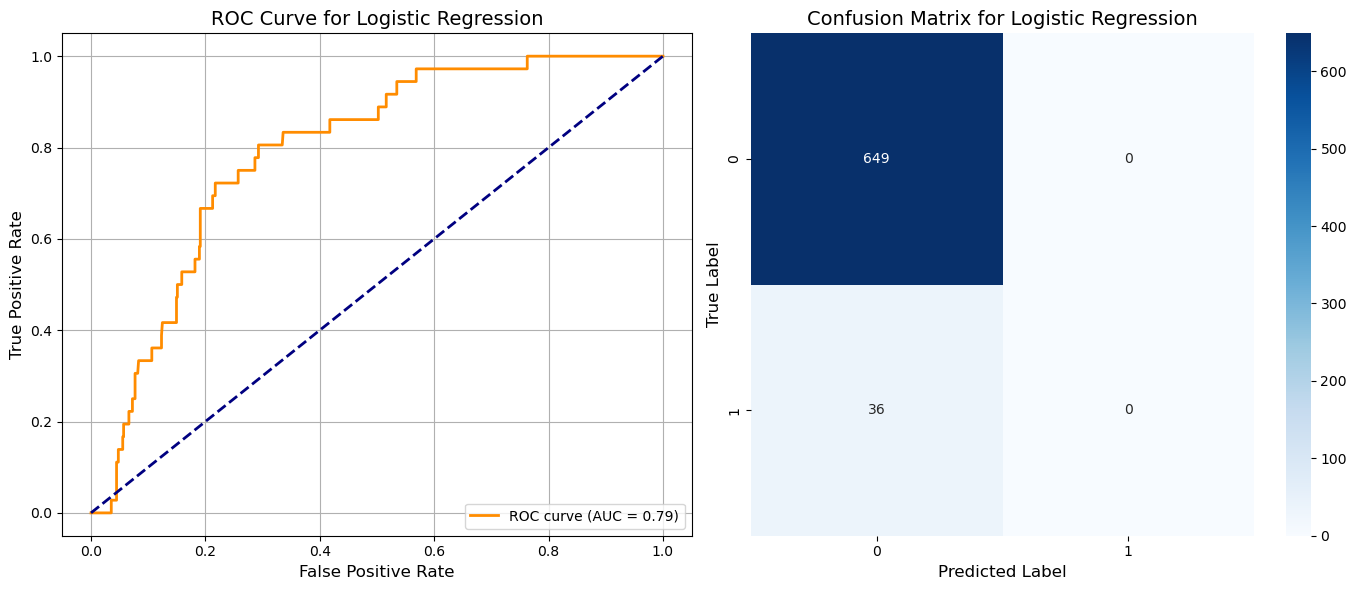

In [26]:
# Make predictions on test data
yp_pred_prob_lr = rfe.predict_proba(X_test)[:, 1]

# calculate the ROC curve
fpr_lr, tpr_lr, th = roc_curve(y_test, yp_pred_prob_lr)

# calculate the AUC
auc_lr = roc_auc_score(y_test, yp_pred_prob_lr)

# Confusion matrix for logistic regression
cm_lr = confusion_matrix(y_test, y_pred_lr)

# option to save results figure
#save_path = 'results/logreg_perfromance.png'
performance_plots(fpr_lr, tpr_lr, auc_lr, cm_lr, 'Logistic Regression', save_path=None)


### K-Nearest Neighbors Model
K-Nearest Neighbors (KNN) is another good model to used when the dependent variable is binary. KNN uses a classification algorithm to make predictions and is well suited for this type of data. 


In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier


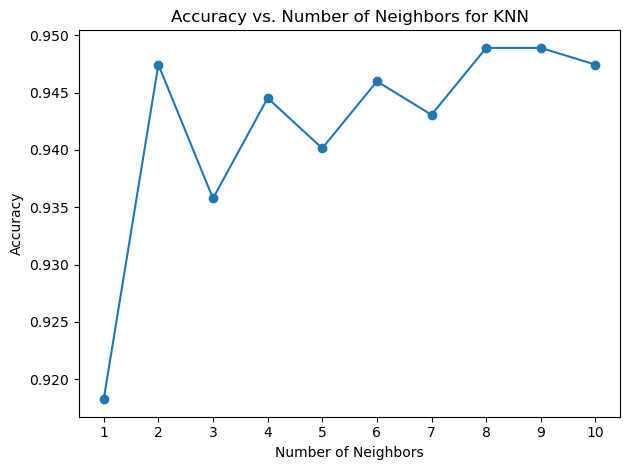

[0.9182481751824818, 0.9474452554744526, 0.9357664233576642, 0.9445255474452555, 0.9401459854014599, 0.945985401459854, 0.9430656934306569, 0.948905109489051, 0.948905109489051, 0.9474452554744526]


In [32]:
# Initialize lists to store accuracy values
accuracies_knn = []

# Iterate over the number of neighbors from 1 to 10
for n_neighbors in range(1, 11):
    # Create a KNN model
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    # Fit the model
    knn.fit(X_train, y_train)
    
    # Predict on the test data
    y_pred_knn = knn.predict(X_test)
    
    # Calculate accuracy
    accuracy_knn = accuracy_score(y_test, y_pred_knn)
    
    # Store accuracy in the list
    accuracies_knn.append(accuracy_knn)

# Create a plot of accuracy vs. number of neighbors
plt.plot(range(1, 11), accuracies_knn, marker='o')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Neighbors for KNN')
plt.xticks(range(1, 11))
plt.tight_layout()
# save plot (optional)
#plt.savefig('results/knn_accuracies.png', dpi = 150, bbox_inches = 'tight')
plt.show()

print(accuracies_knn)

In [34]:
best_accuracy_knn = accuracies_knn[1]
print(best_accuracy_knn)

0.9474452554744526


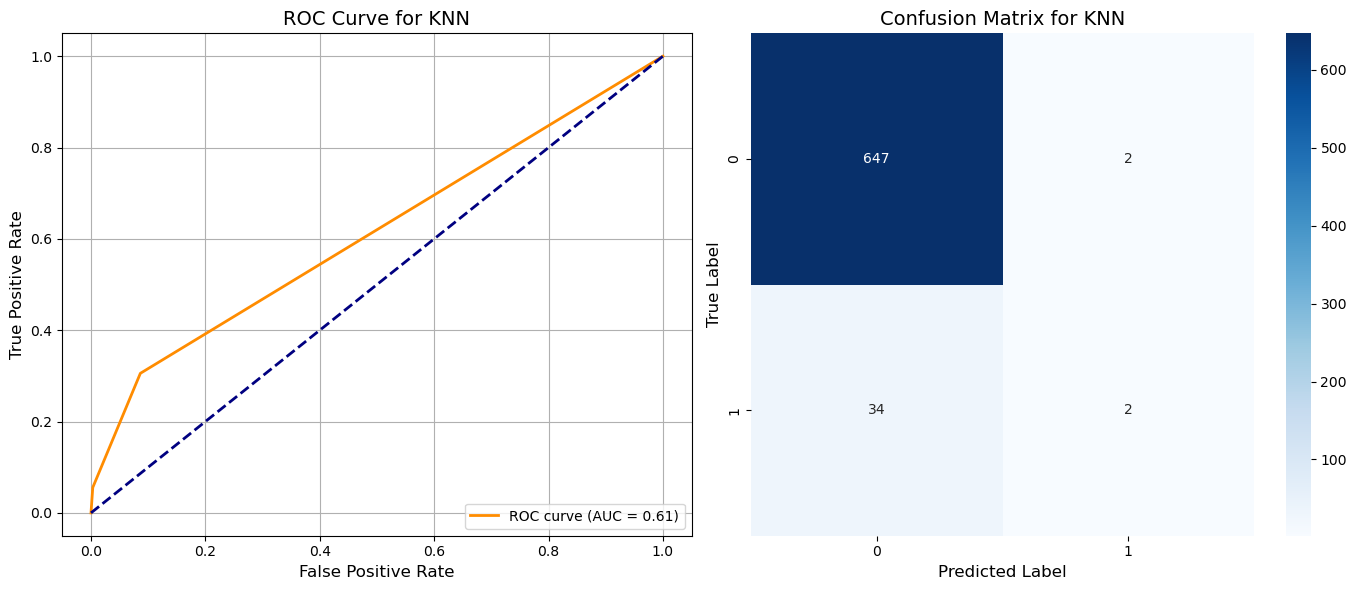

In [38]:
# Create a KNN model
n_neighbors = 2 # neighbors
knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)  

# Fit the model
knn_model.fit(X_train, y_train)

# Predict the probability scores for the positive class
y_pred_prob_knn = knn_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_prob_knn)

# Calculate the AUC 
auc_knn = roc_auc_score(y_test, y_pred_prob_knn)

y_pred_class_knn = knn_model.predict(X_test)
cm_knn = confusion_matrix(y_test, y_pred_class_knn)

# option to save results figure
#save_path = 'results/knn_perfromance.png'
performance_plots(fpr_knn, tpr_knn, auc_knn, cm_knn, 'KNN', save_path=None)

### Support Vector Machine Model
Next I will build is a support vector machine (SVM). These models classify data by calculating the best hyperplane that separates one class of data from another. Therefore, an SVM should perform well with the stroke dataset. 

Accuracy: 0.9474452554744526


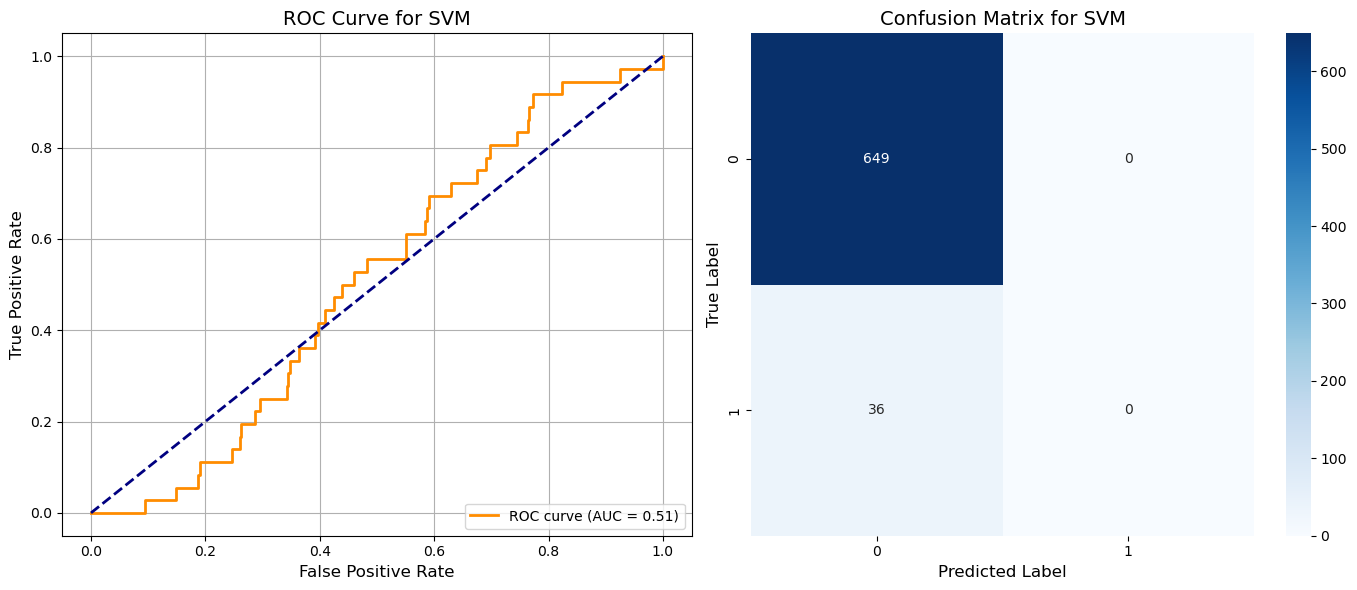

In [42]:
from sklearn.svm import SVC

# Create an SVM model
svm = SVC(probability=True, random_state=42)  # Setting probability=True for ROC curve

# Fit the model
svm.fit(X_train, y_train)

# Predict probabilities on the test data
y_pred_prob_svm = svm.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_prob_svm)

# Calculate AUC (Area Under the Curve)
auc_svm = roc_auc_score(y_test, y_pred_prob_svm)

# Predict on the test data
y_pred_svm = svm.predict(X_test)

# Calculate accuracy
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Accuracy:", accuracy_svm)

# SVM confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)

# option to save results figure
#save_path = 'results/svm_perfromance.png'
performance_plots(fpr_svm, tpr_svm, auc_svm, cm_svm, 'SVM', save_path=None)

## Random Forest

Accuracy: 0.9430656934306569


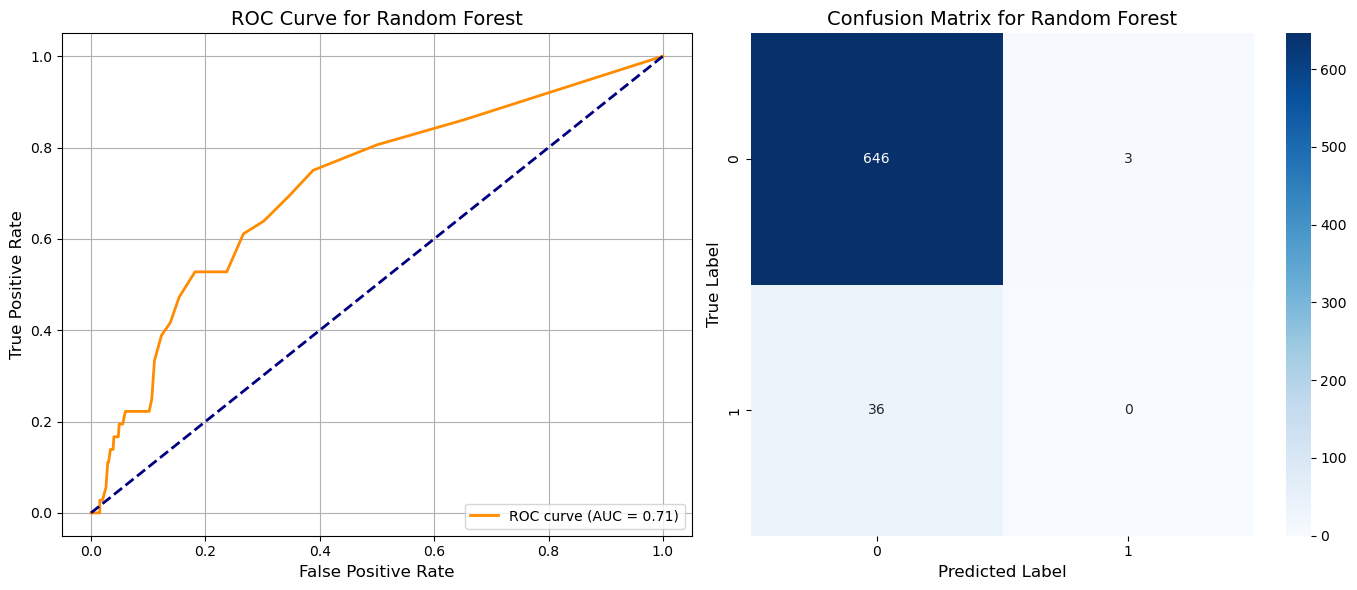

In [46]:
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Fit the model on resampled data
rf_model.fit(X_train, y_train)

# Predict the probability scores for the positive class
y_pred_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_pred_prob_rf)

# Calculate the AUC (Area Under the ROC Curve)
auc_rf = roc_auc_score(y_test, y_pred_prob_rf)

# Predict on the test data and calculate accuracy
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy_rf)

# Confusion matrix for random forest
cm_rf = confusion_matrix(y_test, y_pred_rf)

# option to save results figure
#save_path = 'results/rf_perfromance.png'
performance_plots(fpr_rf, tpr_rf, auc_rf, cm_rf, 'Random Forest', save_path=None)

## XGBoosted

0.9474452554744526


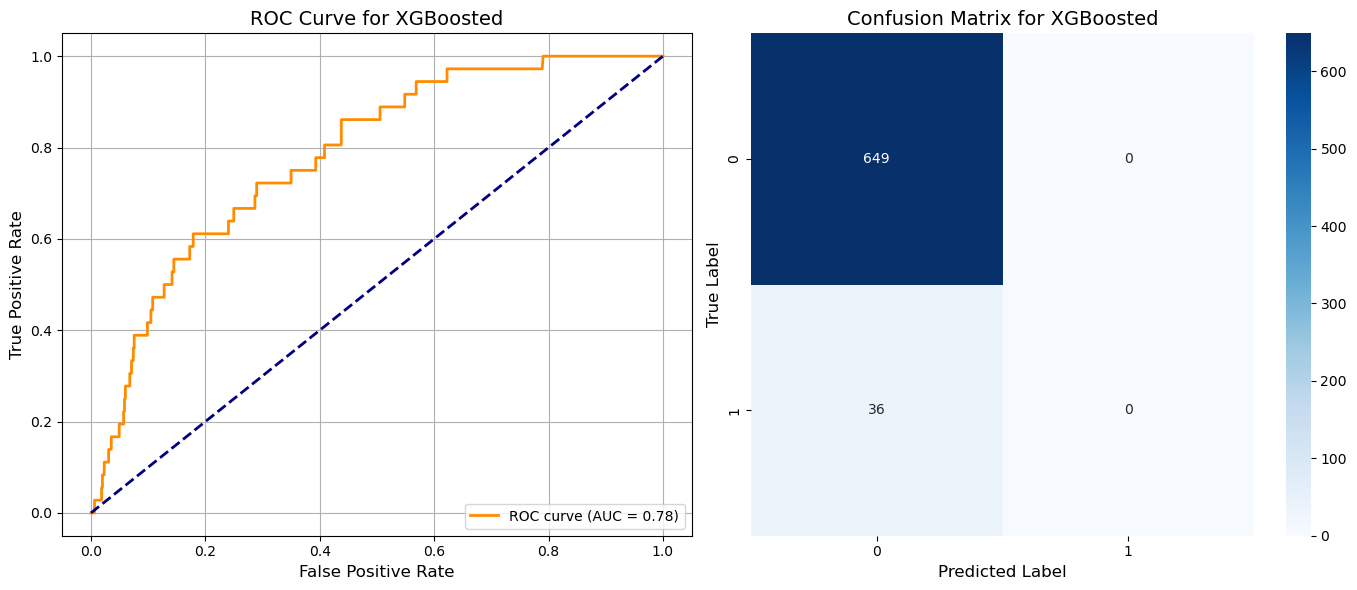

In [60]:
import xgboost as xgb

# Converting Dataset into DMatrix
xgb_train = xgb.DMatrix(X_train, y_train, enable_categorical=True)
xgb_test = xgb.DMatrix(X_test, y_test, enable_categorical=True)

params = {
    'objective': 'binary:logistic',
    'max_depth': 4,
    'learning_rate': 0.05,
    'subsample': 0.8, # helps reduce overfitting
    'random_state': 42 
}
n=50
xgb_model = xgb.train(params = params, dtrain = xgb_train, num_boost_round = n)

y_pred_xgb = xgb_model.predict(xgb_test)
# Convert probabilities to class labels (0 or 1)
y_pred_xgb_labels = (y_pred_xgb >= 0.5).astype(int)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb_labels)
print(accuracy_xgb)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb)

auc_xgb = roc_auc_score(y_test, y_pred_xgb)

# Confusion matrix for XGBoosted 
cm_xgb= confusion_matrix(y_test, y_pred_xgb_labels)

#save_path = 'results/xgb_performance.png'
performance_plots(fpr_xgb, tpr_xgb, auc_xgb, cm_xgb, 'XGBoosted', save_path=None)

### Synthetic Minority Over-sampling Technique (SMOTE) 
SMOTE is a technique used to model when there is class imbalance. SMOTE selects some datapoints and uses a distance measure to generate a new synthetic data point. Only approximately 5% of the data is positive for stroke and all of the models are having trouble identifying stroke. 

In [62]:
# packages for SMOTE
from imblearn.over_sampling import SMOTE

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

## Logistic Regrestion with Over-Sampled Data

In [64]:
# Create a logistic regression model
logreg_smote = LogisticRegression(max_iter=1000)

# Initialize RFE
rfe_lr_smote = RFE(logreg, n_features_to_select=10)  # adjust the number of features to select

# Fit RFE to the training data
rfe_lr_smote.fit(X_train_resampled, y_train_resampled)

# Get the selected features
selected_features_lr_smote = X_train_resampled.columns[rfe.support_]
print("Selected Features:", selected_features_lr_smote)

# Fit the logistic regression model with the selected features
logreg_smote.fit(X_train_resampled[selected_features_lr_smote], y_train_resampled)

# Predict on the test data
y_pred_lr_smote = logreg_smote.predict(X_test[selected_features_lr_smote])

# Calculate accuracy
accuracy_lr_smote = accuracy_score(y_test, y_pred_lr_smote)
print("Accuracy:", accuracy_lr_smote)


Selected Features: Index(['age', 'hypertension', 'heart_disease', 'gender_Male',
       'work_type_Private', 'work_type_Self-employed', 'work_type_children',
       'Residence_type_Urban', 'smoking_status_never smoked',
       'smoking_status_smokes'],
      dtype='object')
Accuracy: 0.8014598540145985


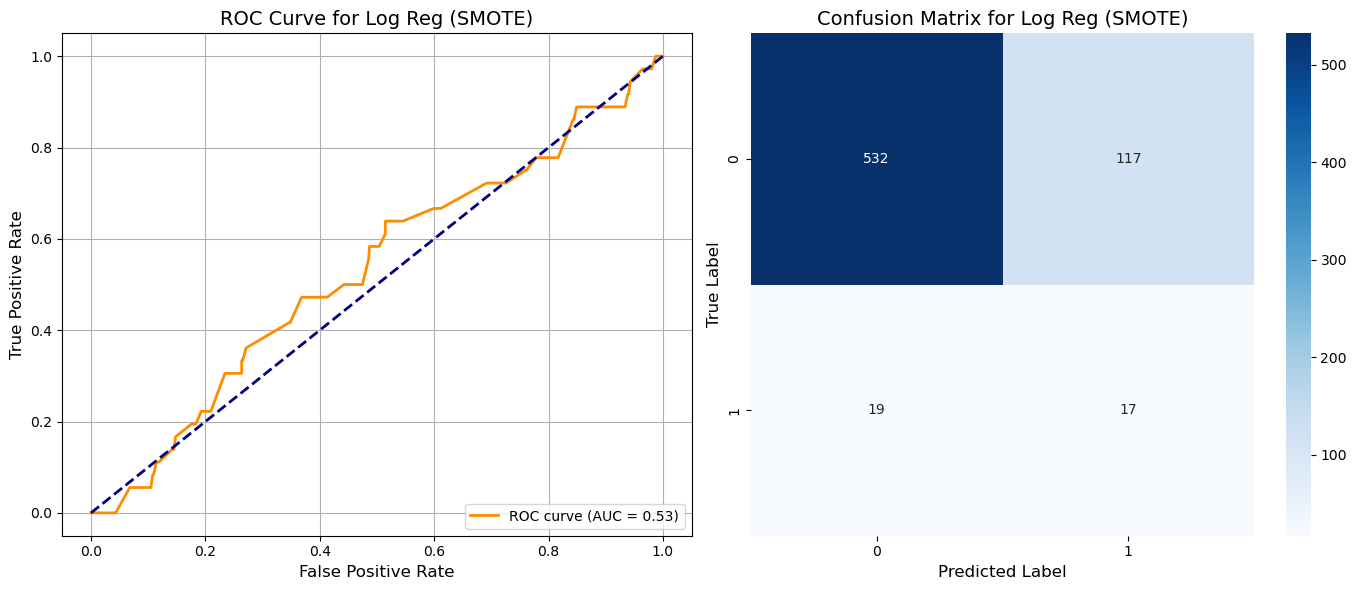

In [68]:
# Make predictions on test data
y_pred_prob_lr_smote = rfe_lr_smote.predict_proba(X_test)[:, 1]

# calculate the ROC curve
fpr_lr_smote, tpr_lr_smote, th = roc_curve(y_test, y_pred_prob_lr_smote)

# calculate the AUC
auc_lr_smote = roc_auc_score(y_test, y_pred_prob_lr_smote)

# Confusion matrix for logistic regression with oversampled data
cm_lr_smote = confusion_matrix(y_test, y_pred_lr_smote)

# option to save plots
#save_path = 'results/lr_smote_performance.png'
performance_plots(fpr_lr_smote, tpr_lr_smote, auc_lr_smote, cm_lr_smote, 'Log Reg (SMOTE)', save_path=None)

## KNN with Over-Sampled Data

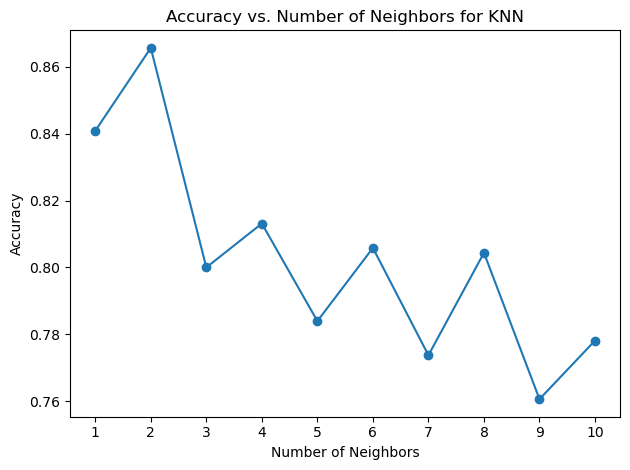

[0.8408759124087591, 0.8656934306569343, 0.8, 0.8131386861313868, 0.7839416058394161, 0.8058394160583942, 0.7737226277372263, 0.8043795620437956, 0.7605839416058394, 0.7781021897810219]


In [70]:
# Initialize lists to store accuracy values
accuracies_knn_smote = []

# Iterate over the number of neighbors from 1 to 10
for n_neighbors in range(1, 11):
    # Create a KNN model
    knn_smote = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    # Fit the model
    knn_smote.fit(X_train_resampled, y_train_resampled)
    
    # Predict on the test data
    y_pred_knn_smote = knn_smote.predict(X_test)
    
    # Calculate accuracy
    accuracy_knn_smote = accuracy_score(y_test, y_pred_knn_smote)
    
    # Store accuracy in the list
    accuracies_knn_smote.append(accuracy_knn_smote)

# Create a plot of accuracy vs. number of neighbors
plt.plot(range(1, 11), accuracies_knn_smote, marker='o')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Neighbors for KNN')
plt.xticks(range(1, 11))
plt.tight_layout()
# save plot (optional)
plt.savefig('results/knn_accuracies_smote.png', dpi = 150, bbox_inches = 'tight')
plt.show()

print(accuracies_knn_smote)

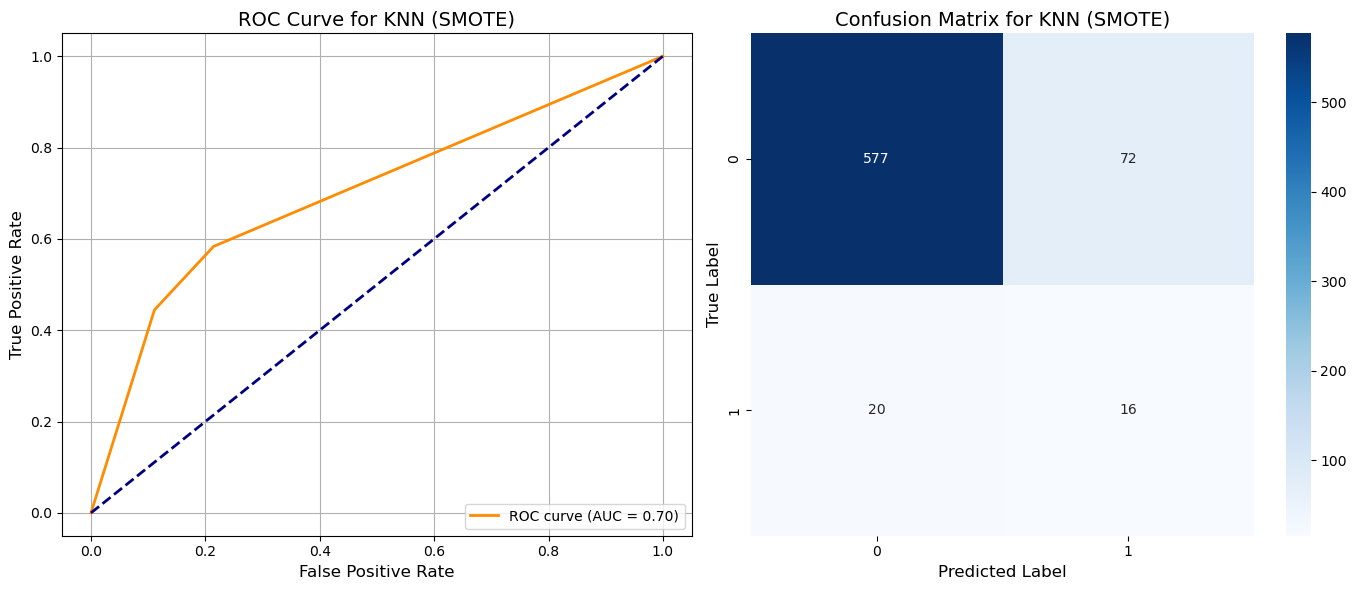

In [74]:
# Create a KNN model
n_neighbors = 2 # neighbors
knn_model_smote = KNeighborsClassifier(n_neighbors=n_neighbors)  

# Fit the model
knn_model_smote.fit(X_train_resampled, y_train_resampled)

# Predict the probability scores for the positive class
y_pred_prob_knn_smote = knn_model_smote.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr_knn_smote, tpr_knn_smote, _ = roc_curve(y_test, y_pred_prob_knn_smote)

# Calculate the AUC (Area Under the ROC Curve)
auc_knn_smote = roc_auc_score(y_test, y_pred_prob_knn_smote)

# Confusion matrix for KNN with oversampled data
y_pred_class_knn_smote = knn_model_smote.predict(X_test)
cm_knn_smote = confusion_matrix(y_test, y_pred_class_knn_smote)

# optional save plots
#save_path = 'results/knn_smote_performance.png'
performance_plots(fpr_knn_smote, tpr_knn_smote, auc_knn_smote, cm_knn_smote, 'KNN (SMOTE)', save_path=None)

## SVM with Over-Sampled Data

Accuracy: 0.7051094890510949


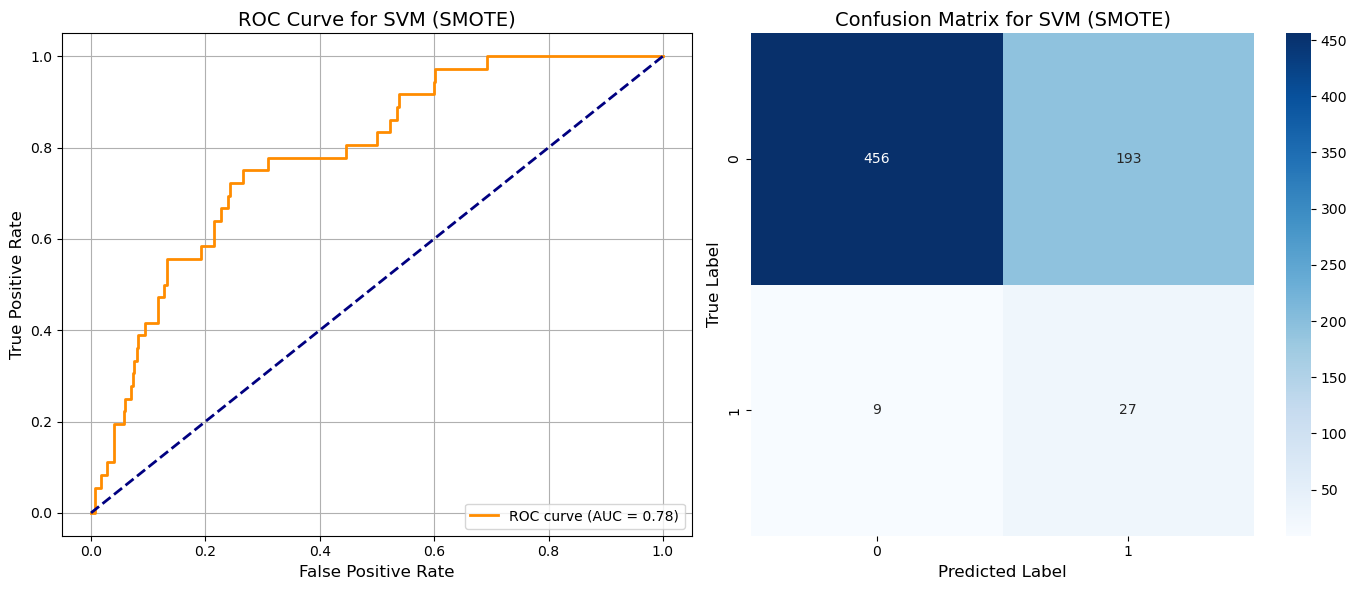

In [78]:
# Create an SVM model
svm = SVC(probability=True, random_state=42)  # Setting probability=True for ROC curve

# Fit the model
svm.fit(X_train_resampled, y_train_resampled)

# Predict probabilities on the test data
y_pred_prob_svm_smote = svm.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr_svm_smote, tpr_svm_smote, _ = roc_curve(y_test, y_pred_prob_svm_smote)

# Calculate AUC (Area Under the Curve)
auc_svm_smote = roc_auc_score(y_test, y_pred_prob_svm_smote)

# Predict on the test data
y_pred_svm_smote = svm.predict(X_test)

# Calculate accuracy
accuracy_svm_smote = accuracy_score(y_test, y_pred_svm_smote)
print("Accuracy:", accuracy_svm_smote)

# Confusion matrix for SVM with oversampled data
cm_svm_smote = confusion_matrix(y_test, y_pred_svm_smote)

#save_path = 'results/svm_smote_performance.png'
performance_plots(fpr_svm_smote, tpr_svm_smote, auc_svm_smote, cm_svm_smote, 'SVM (SMOTE)', save_path=None)

## Random Forest with Over-Sampled Data

Accuracy: 0.8948905109489051


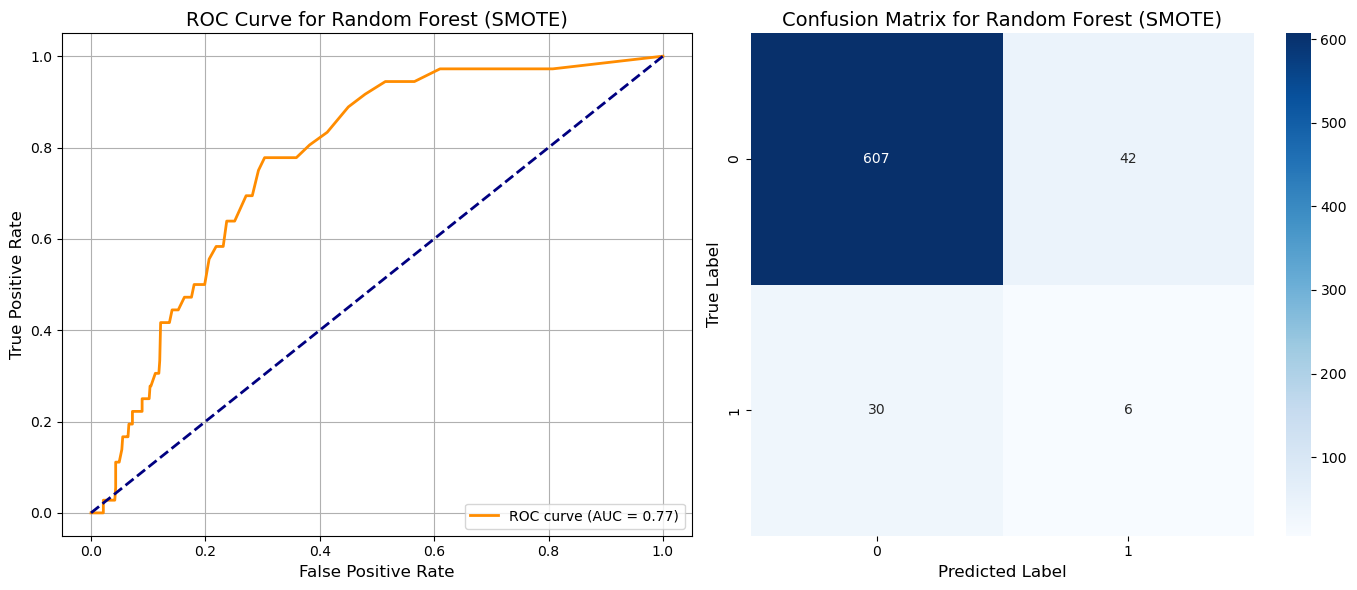

In [82]:
# Create a Random Forest model
rf_model_smote = RandomForestClassifier(random_state=42)

# Fit the model on resampled data
rf_model_smote.fit(X_train_resampled, y_train_resampled)

# Predict the probability scores for the positive class
y_pred_prob_rf_smote = rf_model_smote.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr_rf_smote, tpr_rf_smote, thresholds = roc_curve(y_test, y_pred_prob_rf_smote)

# Calculate the AUC (Area Under the ROC Curve)
auc_rf_smote = roc_auc_score(y_test, y_pred_prob_rf_smote)

# Predict on the test data and calculate accuracy
y_pred_rf_smote = rf_model_smote.predict(X_test)
accuracy_rf_smote = accuracy_score(y_test, y_pred_rf_smote)
print("Accuracy:", accuracy_rf_smote)

# Confusion matrix for random forest with oversampled data
cm_rf_smote = confusion_matrix(y_test, y_pred_rf_smote)

# option to save plots
#save_path = 'results/rf_smote_performance.png'
performance_plots(fpr_rf_smote, tpr_rf_smote, auc_rf_smote, cm_rf_smote, 'Random Forest (SMOTE)', save_path=None)

0.908029197080292


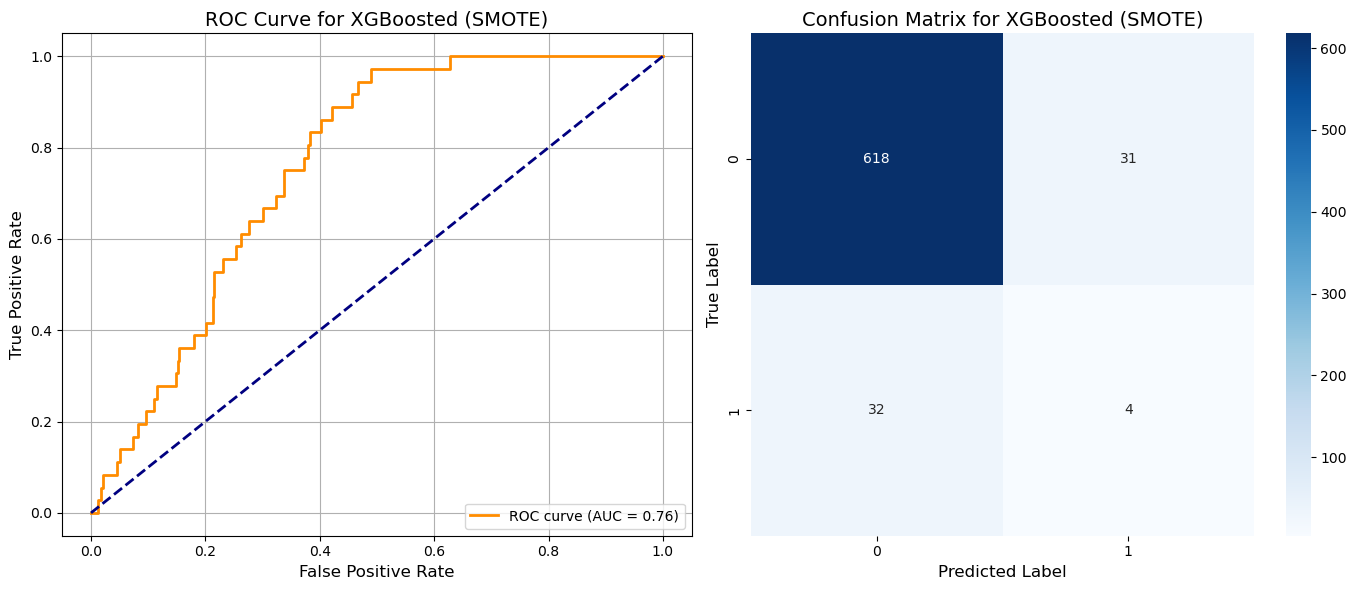

In [86]:
# Converting Dataset into DMatrix
xgb_train_smote = xgb.DMatrix(X_train_resampled, y_train_resampled, enable_categorical=True)
xgb_test_smote = xgb.DMatrix(X_test, y_test, enable_categorical=True)

params = {
    'objective': 'binary:logistic',
    'max_depth': 8,
    'learning_rate': 0.5,
    'random_state': 42 
}
n=50
xgb_model_smote = xgb.train(params = params, dtrain = xgb_train_smote, num_boost_round = n)

y_pred_xgb_smote = xgb_model_smote.predict(xgb_test_smote)
# Convert probabilities to class labels (0 or 1)
y_pred_xgb_labels_smote = (y_pred_xgb_smote >= 0.5).astype(int)
accuracy_xgb_smote = accuracy_score(y_test, y_pred_xgb_labels_smote)
print(accuracy_xgb_smote)

fpr_xgb_smote, tpr_xgb_smote, _ = roc_curve(y_test, y_pred_xgb_smote)
auc_xgb_smote = roc_auc_score(y_test, y_pred_xgb_smote)

# Confusion matrix for XGBoosted over-sampled data
cm_xgb_smote = confusion_matrix(y_test, y_pred_xgb_labels_smote)

# option to save performance plots
# save_path = 'results/xgb_smote_performance.png'
performance_plots(fpr_xgb_smote, tpr_xgb_smote, auc_xgb_smote, cm_xgb_smote, 'XGBoosted (SMOTE)', save_path=None)

## SVM with Grid Search for Hyperparameter Tuning
Implement hyperpramameter tuning by assessing recall to detect positive stroke cases

- The hyperparameter C controls the penalty for misclassification.
- A high C value imposes in a stricter penalty for misclassification.
    - The model will try to classify all training examples correctly, which may reduce bias.
    - This can lead to low bias but high variance, increasing the risk of overfitting.
- A low C value imposes a less strict penalty for misclassification.
    - The model will focus on maximizing the hyperplane margin.
    - This can lead to higher bias but lower variance, increasing the risk of underfitting, but gemeralizes better. 

In [90]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

In [92]:
params_grid = [
    {'C' : [0.01, 0.1, 0.5, 1], 'kernel' : ['linear']},
    {'C' : [0.01, 0.1, 0.5, 1], 'kernel' : ['poly'], 'degree' : [2, 3, 4]},
    {'C' : [0.01, 0.1, 0.5, 1], 'kernel' : ['rbf'], 'gamma': [0.01, 0.05, 0.1, 1]}
] 

classifier = SVC(probability = True, random_state=42)
grid_search_svm_smote = GridSearchCV(
    estimator = classifier,
    param_grid = params_grid,
    scoring = 'recall', #focus on detecting positive stroke cases
    cv = 10,
    n_jobs = -1 
)

grid_search_svm_smote.fit(X_train_resampled, y_train_resampled)

best_recall = grid_search_svm_smote.best_score_
best_parameters = grid_search_svm_smote.best_params_
                                     
print('Best Recall Score:', best_recall)
print('Best Parameters:', best_parameters)
    

Best Recall Score: 0.9645634095634096
Best Parameters: {'C': 1, 'gamma': 0.05, 'kernel': 'rbf'}


Accuracy: 0.8583941605839416


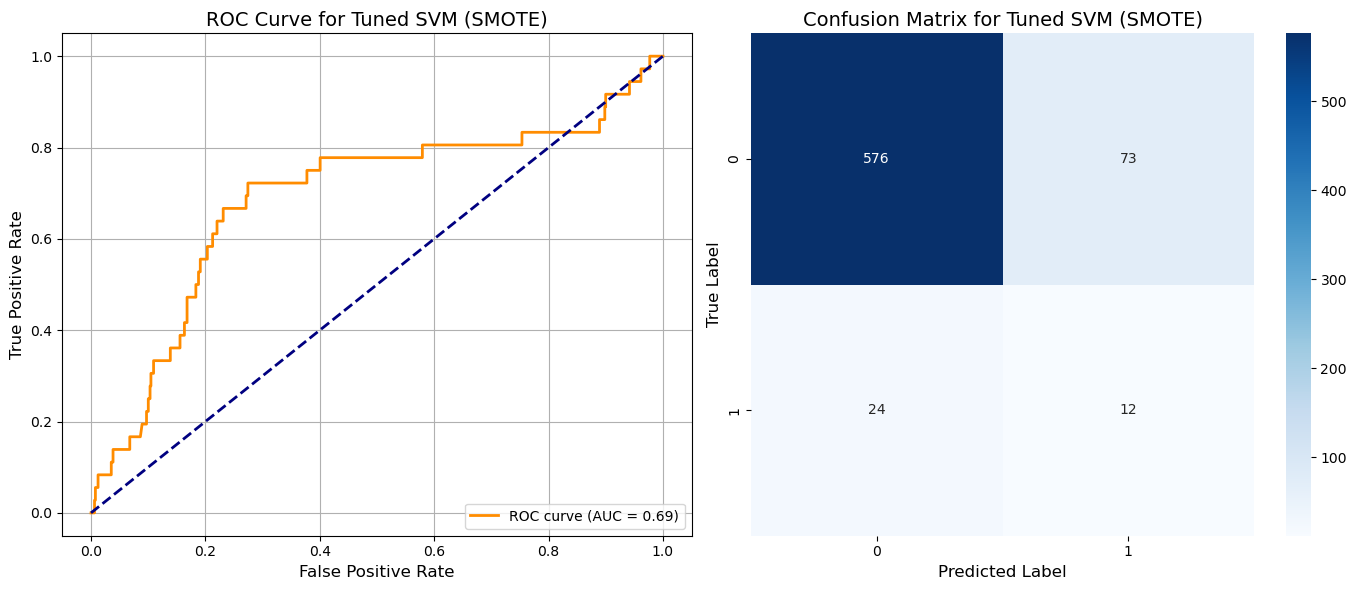

In [96]:
# Predict probabilities for the positive class
best_svm_model = grid_search_svm_smote.best_estimator_

y_pred_prob_svm_smote_tuned = best_svm_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr_svm_smote_tuned, tpr_svm_smote_tuned, _ = roc_curve(y_test, y_pred_prob_svm_smote_tuned)

# Calculate AUC
auc_svm_smote_tuned = roc_auc_score(y_test, y_pred_prob_svm_smote_tuned)

# Predict class labels
y_pred_svm_smote_tuned = best_svm_model.predict(X_test)

# Calculate accuracy
accuracy_svm_smote_tuned = accuracy_score(y_test, y_pred_svm_smote_tuned)
print("Accuracy:", accuracy_svm_smote_tuned)

# Confusion matrix for tuned SVM over-sampled data 
cm_svm_smote_tuned = confusion_matrix(y_test, y_pred_svm_smote_tuned)

# option to save performance plots
#save_path = 'results/tuned_svm_smote_performance.png'
performance_plots(fpr_svm_smote_tuned, tpr_svm_smote_tuned, auc_svm_smote_tuned, cm_svm_smote_tuned, 'Tuned SVM (SMOTE)', save_path=None)

## XGBoost with Grid Search for Hyperparameter Tuning
Implement hyperpramameter tuning by assessing recall to detect positive stroke cases

In [98]:
from xgboost import XGBClassifier

In [100]:
# Create the classifier
xgb_clf = XGBClassifier(eval_metric='logloss', random_state=42)

# Define parameter grid
params_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 1],
    'subsample': [0.6, 0.8, 1.0],
    'scale_pos_weight': [5, 10, 20]  # Tune based on class imbalance, set to 1 if using SMOTE set to [1, 5, 10] else
}

# Grid search with recall 
grid_search_xgb = GridSearchCV(
    estimator=xgb_clf,
    param_grid=params_grid,
    scoring='recall',  
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit on original data (if using SMOTE oversampled data set scale_pos_weight to 1)
grid_search_xgb.fit(X_train, y_train)

# Best model and performance
best_xgb_model = grid_search_xgb.best_estimator_
print("Best Parameters:", grid_search_xgb.best_params_)
print("Best Recall Score:", grid_search_xgb.best_score_)


Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'scale_pos_weight': 20, 'subsample': 0.6}
Best Recall Score: 0.7921182266009852


Accuracy: 0.6846715328467153


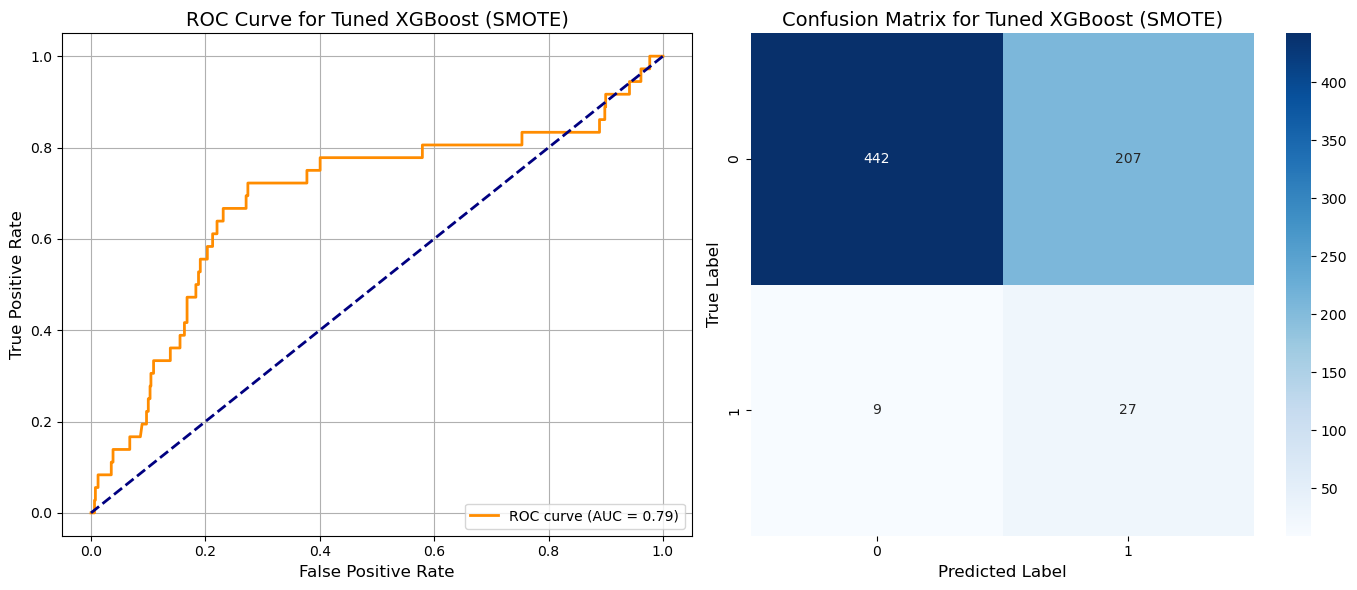

In [102]:
# Predict probabilities for the positive class
y_pred_prob_xgb_smote_tuned = best_xgb_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr_xgb_smote_tuned, tpr_xgb_smote_tuned, _ = roc_curve(y_test, y_pred_prob_svm_smote_tuned)

# Calculate AUC
auc_xgb_smote_tuned = roc_auc_score(y_test, y_pred_prob_xgb_smote_tuned)

# Predict class labels
y_pred_xgb_smote_tuned = best_xgb_model.predict(X_test)

# Calculate accuracy
accuracy_xgb_smote_tuned = accuracy_score(y_test, y_pred_xgb_smote_tuned)
print("Accuracy:", accuracy_xgb_smote_tuned)

# Confusion matrix for tuned SVM over-sampled data 
cm_xgb_smote_tuned = confusion_matrix(y_test, y_pred_xgb_smote_tuned)

# option to save performance plots
#save_path = 'results/tuned_xgb_smote_performance.png'
performance_plots(fpr_xgb_smote_tuned, tpr_xgb_smote_tuned, auc_xgb_smote_tuned, cm_xgb_smote_tuned, 'Tuned XGBoost (SMOTE)', save_path=None)
